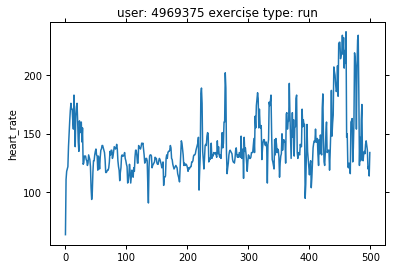

In [ ]:
#Maybe it will make sense to edit Julian's json-creating file instead if it provides a natural way to access the actual values...
import matplotlib.pyplot as plt
import pickle
import ijson
from IPython.display import clear_output

def getNextDataPointSequential(objects):
    nextDataPoint=__convert(objects.next())
    return nextDataPoint

def __convert(unicData): #Converts the unicode text in a dictionary to ascii
        #Shamelessly lifted from http://stackoverflow.com/questions/13101653/python-convert-complex-dictionary-of-strings-from-unicode-to-ascii
        if isinstance(unicData, dict):
            return {__convert(key): __convert(value) for key, value in unicData.iteritems()}
        elif isinstance(unicData, list):
            return [__convert(element) for element in unicData]
        elif isinstance(unicData, unicode):
            return unicData.encode('utf-8')
        else:
            return unicData

def testDataPoint(dp, dp_index, black_listed_users):
    #Takes a data point dp and runs through the attributes, testing whether the values are reasonable
    #If not, it displays relevant information to the user and asks them whether or not to reject the data point
    
    #Returns a boolean True if the data point is OK and False otherwise
    #attributes = ['speed', 'altitude', 'gender', 'heart_rate', 'id', 'latitude', 'longitude', 'sport', 'timestamp', 'url', 'userId']
    
    if dp["userId"] in black_listed_users:
        return False
    
    attributes = ['altitude', 'gender', 'heart_rate', 'id', 'latitude', 'longitude', 'sport', 'timestamp', 'url', 'userId']
    attTesters = {'speed': speedTest, 'altitude': altitudeTest, 'gender': genderTest, 'heart_rate': heart_rateTest,
                  'id': idTest, 'latitude': latitudeTest, 'longitude': longitudeTest, 'sport': sportTest, 
                  'timestamp': timestampTest, 'url': urlTest, 'userId': userIdTest}
    isSequence={'altitude':True, 'gender':False, 'heart_rate':True, 'id':False, 'latitude':True, 'longitude':True,
                             'speed':True, 'sport':False, 'timestamp':True, 'url':False, 'userId':False, 'time_elapsed': True, 
                             'distance':True, 'new_workout':True, 'derived_speed':True}#Handcoded
    for att in attributes:
        if isSequence[att]:
            attSeqLen = len(dp[att])
            if attSeqLen != 500:
                clear_output()
                print("Data point length is: " + str(attSeqLen))
                #keep_wrong_len = query_user_length()
                #if keep_wrong_len is False:
                #    return False
                return False
        tester = attTesters[att]
        flag = tester(dp[att], dp) #False positives are less problematic here than misses
        if flag:
            clear_output()
            print("Data point number: " + str(dp_index))
            userDecision = queryUser(dp, att, black_listed_users)
            if userDecision is False:
                return False
    return True
    
        
def speedTest(val, dp):
    lastS = val[0]
    for s in val:
        if s > 100:
            return True
        elif abs(s-lastS) > 30:
            return True
        lastS = s
        #Might want to check different speeds for different activities
    return False

def altitudeTest(val, dp):
    lastA = val[0]
    for a in val:
        if a>10000:
            return True
        elif abs(a-lastA)>1000:
            return True
        lastA = a
    return False       

def genderTest(val, dp):
    return False #Categorical

def heart_rateTest(val, dp):
    lastH = val[0]
    for h in val:
        if h > 240:
            return True
        elif abs(h-lastH) > 70:
            return True
        lastH = h
    return False

def idTest(val, dp):
    return False #Categorical

def latitudeTest(val, dp):
    lastL = val[0]
    for l in val:
        if l > 90 or l < -90:
            return True
        elif abs(l-lastL) > .1:
            return True
        lastL = l
    return False

def longitudeTest(val, dp):
    lastL = val[0]
    for l in val:
        if l > 180 or l < -180:
            return True
        elif abs(l-lastL) > .1:
            return True
        lastL = l
    return False

def sportTest(val, dp):
    return False #Categorical

def timestampTest(val, dp):
    return False #Not sure what a good test would be here

def urlTest(val, dp):
    return False #Categorical

def userIdTest(val, dp):
    return False #Categorical


def queryUser(dp, att, black_listed_users):
    #Asks the user whether or not they want to retain the data point by providing graphical information and requesting a user response
    
    #Display information relevant to user's decision
    plotContext(dp, att)
    
    #Ask the user somehow
    userNotResponded = True
    while userNotResponded:
        rawResponse = raw_input('Keep the Data Point? [Y/N]: ')
        if rawResponse == 'y' or rawResponse == 'Y':
            response = True
            userNotResponded = False
        elif rawResponse == 'n' or rawResponse == 'N':
            response = False
            userNotResponded = False
        elif rawResponse == 'u' or rawResponse == 'U':
            response = False
            userNotResponded = False
            black_listed_users.add(dp["userId"])
        else:
            print("That is not a valid response. Try again...")
    print('Thanks! Now fetching next potentially agregious data point')
    return response

def query_user_length():
    userNotResponded = True
    while userNotResponded:
        rawResponse = raw_input('Keep the Data Point? [Y/N]: ')
        if rawResponse == 'y' or rawResponse == 'Y':
            response = True
            userNotResponded = False
        elif rawResponse == 'n' or rawResponse == 'N':
            response = False
            userNotResponded = False
        else:
            print("That is not a valid response. Try again...")
    print('Thanks! Now fetching next potentially agregious data point')
    return response
    
def plotContext(dp, att):
    #Takes a data point, an attribute, and a sequence position, and plots the sequence position point in the context
    #of the rest of the sequence    
    #Intended for use only with sequential attributes
    
    x = range(500)
    y = dp[att]
    title = 'user: ' + str(dp["userId"]) + ' exercise type: ' + dp["sport"]
    %matplotlib inline
    plt.figure(1)
    plt.plot(x,y)
    plt.ylabel(att)
    plt.xlabel("Data point index")
    plt.title(title)
    plt.show()
    
    plt.figure(2)
    initial_time = dp["timestamp"][0]
    x = [t-initial_time for t in dp["timestamp"]]
    plt.plot(x,y)
    plt.ylabel(att)
    plt.xlabel("Elapsed time")
    plt.show()
    
def saveExcisedList(badList, excisedListFileName):
    #Saves the list of bad data points to a file
    with open(excisedListFileName, "wb") as f:
        pickle.dump(badList, f)
        
def loadExcisedList(excisedListFileName):
    with open(excisedListFileName, "rb") as f:
        exc_l = pickle.load(f)
    return exc_l
    
def main():
    #Opens data file, runs through data points, creates a list of data points to be excised, and saves the list to a file
    dataFileName = "../multimodalDBM/endomondoHR_proper.json"
    excisedListFileName = "excisedData.p"
    
    f = open(dataFileName, 'r')#open data file
    
    rawDataPoints = ijson.items(f, 'users.item')
      
    try:
        excisedList = loadExcisedList(excisedListFileName)
        excised_set = set(excisedList)
        print("Excised list loaded")
    except:
        print("Cannot find excised list. Starting from scratch.")
        excisedList = []
        excised_set = set()
    
    #run through data points
    black_listed_users = set()
    for i, dp in enumerate(rawDataPoints):
        dataPoint = __convert(dp)
        if i in excised_set:
            pass
        elif testDataPoint(dataPoint, i, black_listed_users) is False:
            excisedList.append(i)#MAKE SURE THAT THIS INDEXING IS CORRECT. MIGHT WANT TO LOAD DATA POINTS BY INDEX TO BE SURE
            excised_set.add(i)
            saveExcisedList(excisedList, excisedListFileName)
            print("Saving progress")
    print("Done!!!")
    print("Total number of excised data points: " + str(len(excisedList)))
    saveExcisedList(excisedList, excisedListFileName)
    f.close()
            
        
if __name__ == '__main__':
    main()

In [1]:
rawResponse = raw_input('Keep the Data Point? [Y/N]: ')
print(rawResponse)

Keep the Data Point? [Y/N]: Y
Y
